In [1]:

from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor
from doctr.io import DocumentFile
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
import torch
from backend.pytorch import DET_ARCHS, RECO_ARCHS, forward_image, load_predictor
from doctr.utils.visualization import visualize_page


doc_path = "../data/mydata/flight.png"
if doc_path.endswith((".pdf", ".PDF")):
    doc = DocumentFile.from_pdf(doc_path)
else:
    doc = DocumentFile.from_images(doc_path)
page = doc[0]

forward_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

predictor = load_predictor(
    det_arch=DET_ARCHS[0],
    reco_arch=RECO_ARCHS[0],
    assume_straight_pages=True,
    straighten_pages=False,
    export_as_straight_boxes=False,
    disable_page_orientation=False,
    disable_crop_orientation=False,
    bin_thresh=0.3,
    box_thresh=0.1,
    device=forward_device,
)

# Forward the image to the model
seg_map = forward_image(predictor, page, forward_device)
seg_map = np.squeeze(seg_map)
seg_map = cv2.resize(seg_map, (page.shape[1], page.shape[0]), interpolation=cv2.INTER_LINEAR)

# Run OCR
out = predictor([page])
page_export = out.pages[0].export()
img = out.pages[0].synthesize()

/Users/amaljoe/Desktop/Workspace/IITB/CS772/doctr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from translation import update_page_with_big_boxes

page_export = update_page_with_big_boxes(page, page_export)


0: 1024x864 10 titles, 18 plain texts, 6 abandons, 7 figures, 2 figure_captions, 281.3ms
Speed: 8.2ms preprocess, 281.3ms inference, 80.4ms postprocess per image at shape (1, 3, 1024, 864)


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

(np.float64(-0.5), np.float64(1739.5), np.float64(2095.5), np.float64(-0.5))

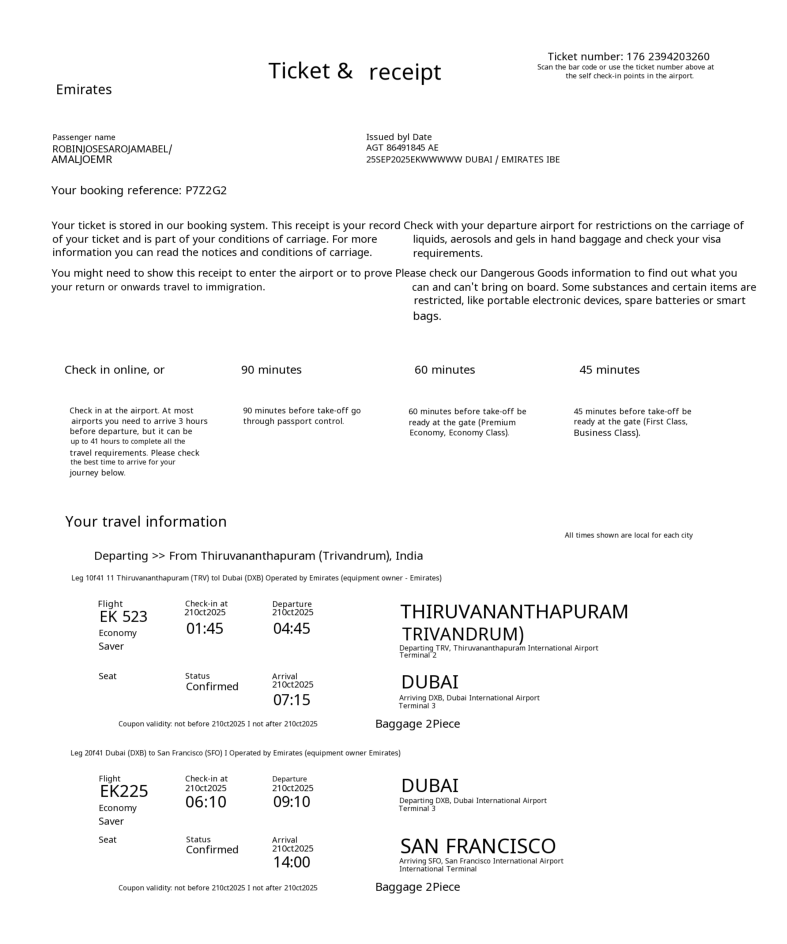

In [4]:

from utils import synthesize_page
syn = synthesize_page(page_export, font_family="../fonts/noto-mal.ttf")
plt.figure(figsize=(12, 12))
plt.imshow(syn)
plt.axis('off')